In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid
import glob
import pickle

# ML Imports
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
PROCESSED_DIR = "data/processed"

## 1. Load Data
---

In [3]:
# Raw Data
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_with_ccp_03.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

In [4]:
Xi_mice = pd.read_csv("data/imputed/full_dataset/mice_qvars_02.tsv", sep="\t")
Xi_mice = Xi_mice.loc[Xi_mice.join(data_df['fna3_cluster_n']).dropna(subset='fna3_cluster_n').index]

In [6]:
# Drop due to high missingness
to_drop = ["Amyloid type","Secondary organ","Arrhythmia ","(Autonomic)",
           "(Peripheral)","SIFE M-component","UIFE M-component",
           "Education","Abdominal fat pad CR staining", "Bone marrow CR staining"]

# Create dataset
Xi_mice_bu_df = utils.data_formatter(
    Xi_mice.join(data_df.loc[Xi_mice.index, amyloid.catvars]).drop(columns=to_drop).dropna()
)

# Filtered dataset (for complete categoricals)
X_filt = Xi_mice_bu_df.copy()
y_filt = data_df.loc[Xi_mice_bu_df.index, 'fna3_cluster_n'].map({'Low':0,'Intermediate':1, 'High': 2})

# Full dataset
X = pd.DataFrame(StandardScaler().fit_transform(Xi_mice.values), index=Xi_mice.index, columns=Xi_mice.columns)
y = data_df.loc[Xi_mice.index, 'fna3_cluster_n'].map({'Low':0,'Intermediate':1, 'High': 2})

Using 29 quantitative variables.
Using 33 categorical variables.
Total samples x feaures (one-hot encoded): (1599 x 71)


## 2. Modeling
---

* `hyperopt` ran for all classification models (MLP, random forest, naive bayes, KNN, XGBoost, SVC, Tree) with `05b_hyperopt.py`
* Results loaded here and cross validation metrics computed

In [7]:
NJOBS = -1
RANDOM_STATE = 122

In [8]:
# Load models
hyperopt_estimators = dict()
hyperopt_models = dict()

for filename in glob.glob("data/subgroup_prediction/*.pkl"):
    with open(filename, "rb") as file:
        _name = filename.split("/")[-1].split("_")[-1].split(".pkl")[0]
        hyperopt_estimators[_name] = pickle.load(file)
        hyperopt_models[_name] = hyperopt_estimators[_name].best_model()['learner']

In [9]:
for mod in hyperopt_models.keys():
    hyperopt_models[mod].fit(X, y)

[09:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.



## 3. Feature Importance
---

In [25]:
shap_values = dict()

for filename in glob.glob("data/subgroup_prediction/shap/*.pkl"):
    with open(filename, "rb") as file:
        _name = filename.split("/")[-1].split("_")[-1].split(".pkl")[0]
        shap_values[_name] = pickle.load(file)

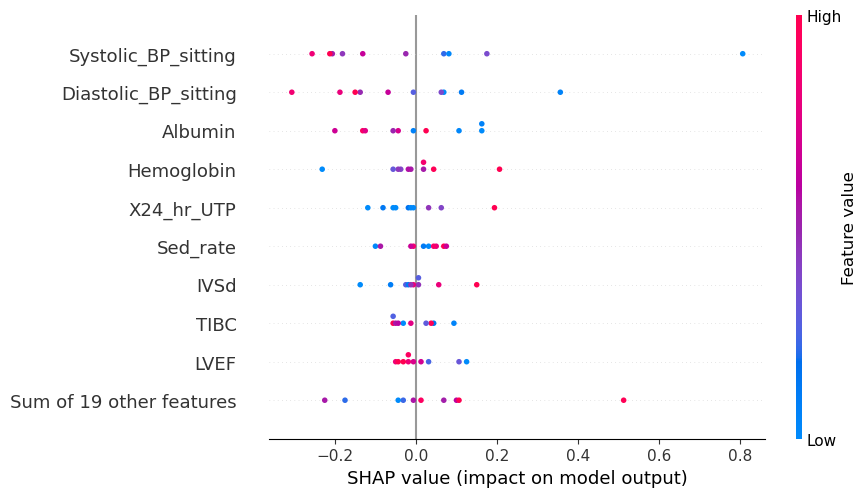

In [30]:
shap.plots.beeswarm(shap_values['mlp'])

In [ ]:
min_importance = 0.01
figsize=(4,5)

fig, ax = plt.subplots(figsize=figsize)

features_df[features_df['importance']>0.01]['importance'].sort_values(ascending=True).rename(
    index=amyloid.ddict_unclean).plot.barh(
        ax=ax, width=1, edgecolor='k', color='lightblue')
ax.set_title("Feature importances using MDI")
fig.tight_layout()

_ = ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)

In [ ]:
shap_explainers = shap.Explainer(best_rf.predict, X_train)
shap_values = shap_explainers(X_train)

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.beeswarm(shap_low_values, show=False)

In [ ]:
shap.plots.beeswarm(shap_intermediate_values, show=False)

In [ ]:
shap.plots.beeswarm(shap_high_values, show=False)

## Old
---

In [ ]:
# # Split data
# X_train, X_test, y_train, y_test = train_test_split(
#     Xi_mice_bu_df, y, 
#     test_size=test_size, random_state=RANDOM_STATE)

# print("Train size (n={})".format(X_train.shape[0]))
# print("Test size (n={})".format(X_test.shape[0]))

# models = dict()
# param_grids = dict()
# grid_searches = dict()

# # Naive Bayes
# param_grids["nb"] = {'var_smoothing': np.logspace(0,-9, num=100)}
# models["nb"] = GaussianNB()

# # KNN
# param_grids["knn"] = {
#     'n_neighbors': [3, 5,10,15],
#     'weights': ['uniform','distance'],
#     'metric': ['minkowski']
# }
# models["knn"] = KNeighborsClassifier()

# # Random Forest
# param_grids["rf"] = {
#     'n_estimators': range(100,1000,100),
#     'max_depth': [5, 10, 15, 20, 25],
#     'criterion':["gini","entropy"],
# }
# models["rf"] = BalancedRandomForestClassifier(sampling_strategy="all", replacement=True, bootstrap=False)

# # XGBoost
# param_grids["xgb"] = {
#     'max_depth': range (2, 10, 1),
#     'n_estimators': range(100,1000,100),
#     'learning_rate': [0.1, 0.01, 0.001],
# }
# models["xgb"] = XGBClassifier(objective= 'multi:softmax', nthread=8, seed=RANDOM_STATE)

In [98]:
# best_models = dict()

# for key in models.keys():
#     grid_searches[key] = GridSearchCV(models[key], param_grid=param_grids[key], cv=CV, n_jobs=NJOBS)
#     grid_searches[key].fit(Xi_mice_scaled, y_full)
#     best_models[key] = grid_searches[key].best_estimator_

In [ ]:
# def comp_matrix(y_pred, y_test):
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average='weighted')
#     recall = recall_score(y_test, y_pred, average='weighted')

#     print("Accuracy:", accuracy)
#     print("Precision:", precision)
#     print("Recall:", recall)

#     # Create the confusion matrix
#     cm = confusion_matrix(y_test, y_pred)
#     ConfusionMatrixDisplay(confusion_matrix=cm).plot()